In [272]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [273]:
df = pd.read_csv("Breast_Cancer.csv")
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


<Axes: xlabel='Status', ylabel='Count'>

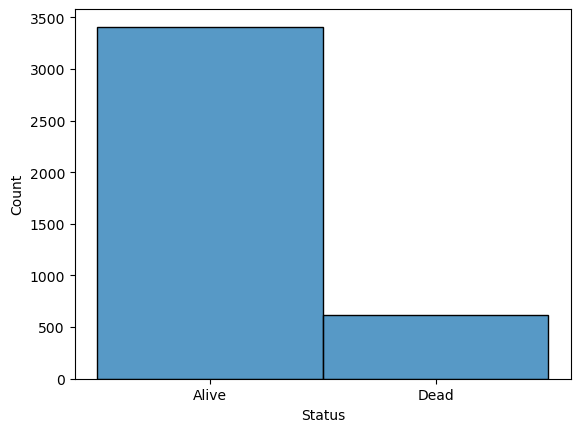

In [274]:
sns.histplot(df.Status)

<Axes: xlabel='Age', ylabel='Count'>

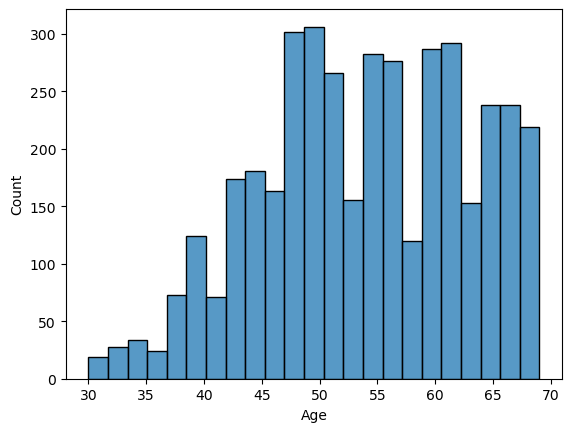

In [275]:
sns.histplot(df.Age)

In [276]:
#changing the values of last column to numerical
df['Status'] = (df['Status']=='Dead').astype(int)

In [277]:
#checking the distribution of target column remained the same after  renaming
df.Status.value_counts()

Status
0    3408
1     616
Name: count, dtype: int64

In [278]:
#renaming all columns to fit the same standard
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [279]:
df.dtypes

age                        int64
race                      object
marital_status            object
t_stage_                  object
n_stage                   object
6th_stage                 object
differentiate             object
grade                     object
a_stage                   object
tumor_size                 int64
estrogen_status           object
progesterone_status       object
regional_node_examined     int64
reginol_node_positive      int64
survival_months            int64
status                     int32
dtype: object

In [280]:
df.describe()
#no suspicious values

,age,tumor_size,regional_node_examined,reginol_node_positive,survival_months,status
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962,0.153082
std,8.963134,21.119696,8.099675,5.109331,22.921430,0.360111
min,30.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000,0.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000,0.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000,0.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000,1.000000


In [281]:
#checking number of unique values
for col in df.columns:
    print(col)
    print(df[col].nunique())
    print()

age
40

race
3

marital_status
5

t_stage_
4

n_stage
3

6th_stage
5

differentiate
4

grade
4

a_stage
2

tumor_size
110

estrogen_status
2

progesterone_status
2

regional_node_examined
54

reginol_node_positive
38

survival_months
107

status
2



In [282]:
#checking for null values
df.isna().sum()

age                       0
race                      0
marital_status            0
t_stage_                  0
n_stage                   0
6th_stage                 0
differentiate             0
grade                     0
a_stage                   0
tumor_size                0
estrogen_status           0
progesterone_status       0
regional_node_examined    0
reginol_node_positive     0
survival_months           0
status                    0
dtype: int64

In [283]:
#splitting the data 60:20:20

from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(2414, 805, 805)

In [284]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [285]:
y_train = df_train.status.values
y_val = df_val.status.values
y_test = df_test.status.values

del df_train['status']
del df_val['status']
del df_test['status']

In [286]:
#checking correlation for categorical and numerical values
categorical = list(df.dtypes[df.dtypes=='object'].index)
numerical = list(df.dtypes[df.dtypes!='object'].index)
from sklearn.metrics import mutual_info_score

In [287]:
def mutual_info_status_score(series):
    return mutual_info_score(series, df_full_train.status)

In [288]:
mi = df_full_train[categorical].apply(mutual_info_status_score)
mi.sort_values(ascending=False)

6th_stage              0.034443
n_stage                0.033396
progesterone_status    0.014918
differentiate          0.014750
grade                  0.014750
estrogen_status        0.013219
t_stage_               0.012877
marital_status         0.004001
a_stage                0.003642
race                   0.002912
dtype: float64

In [289]:
#we can see the bottom 3 are least correlated with target column, order of magnitude less so we will discard them when training

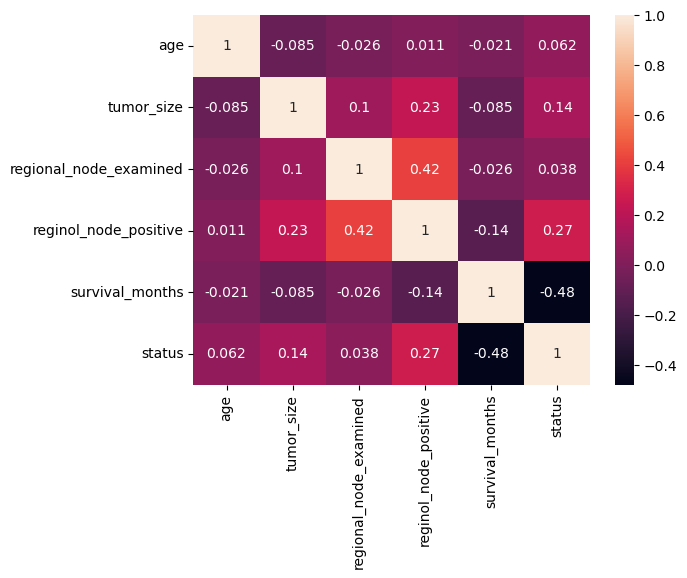

In [290]:
#numerical values correlation
sns.heatmap(df_full_train[numerical].corr(), annot=True)
plt.show()

In [291]:
# no differences as drastic as with categorical values so we will keep all of numerical features

In [292]:
to_drop = ['a_stage', 'race', 'marital_status']
for set in [df_train, df_val, df_full_train, df_test]:
    set.drop(columns=to_drop, inplace=True)



In [304]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\U6071363\Anaconda3\envs\zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [305]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8894409937888199

In [306]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8849678058444774